# Experience : Risk a l'aversion

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
# Ajouter le dossier src au chemin d'importation
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

In [3]:
import matplotlib.pyplot as plt
import torch 
import numpy as np

In [4]:
from environments.risk_aversion_env import RiskAversionEnvironment
from models.qlearning import QLearning

### Configuration de l'environnement

In [5]:
# Configuration de l'environnement
initial_energy = torch.tensor([10])  # Énergie initiale de l'agent
weights = torch.tensor([1.0])  # Poids pour l'énergie interne
exponents = [2, 2]  # Non-linéarité du drive
effects = {}  # Placeholder pour les effets

# Paramètres pour les rewards risqués et non risqués
risky_reward = 8  # Énergie ajoutée pour l'état risqué
non_risky_reward = 2  # Énergie ajoutée pour l'état non risqué
risky_probability = 0.25  # Probabilité d'obtenir l'énergie dans l'état risqué

setpoint_energy = torch.tensor([0])  # Setpoint pour l'énergie optimale

# Instanciation de l'environnement
env = RiskAversionEnvironment(
    H=initial_energy,
    setpoints=setpoint_energy,
    weights=weights,
    exponents=exponents,
    effects=effects,
    risky_reward=risky_reward,
    non_risky_reward=non_risky_reward,
    risky_prob=risky_probability,
)

### Configuration de l'agent

In [6]:
# Création de la Q-table pour l'expérience aversion au risque

# Instancier l'agent Q-learning
state_size = 2
action_size = 2  

alpha = 0.25 # Taux d'apprentissage
gamma = 0.8 # Discount factor
beta = 10 # Facteur d'exploration

agent = QLearning(state_size=state_size, action_size=action_size, alpha=alpha, gamma=gamma, beta=beta)

### Entraînement du modèle

In [18]:
# Configuration pour l'apprentissage
episodes = 300  # Nombre total d'épisodes
reward_history = []  # Récompenses cumulées par épisode
state_histories = []  # Historique des états par épisode
risky_preferences = []  # Préférence pour l'état risqué par épisode
non_risky_preferences = []  # Préférence pour l'état non risqué par épisode

internal_states = []

for episode in range(episodes):
    internal_state, markov_state, current_timestep = env.reset()  # Réinitialiser l'environnement
    internal_state = int(internal_state)
    total_reward = 0  # Récompense totale pour l'épisode
    done = False
    state_history = [internal_state]
    while not done:
        # Choisir une action
        action = agent.choose_action(markov_state)

        # Effectuer une étape
        internal_state, reward, done, next_markov_state, current_timestep  = env.step(action)

        internal_state = int(internal_state)

        # Mise à jour Q-learning
        agent.update_q_value(markov_state, action, reward, next_markov_state)

        # Mettre à jour l'état courant
        markov_state = next_markov_state
        total_reward += reward

        # Ajouter l'état courant à l'historique
        state_history.append(internal_state)
    
    state_histories.append(state_history)

    # Ajouter les métriques de l'épisode aux historiques globaux
    #print(f"Etat interne final : {internal_state}")
    #print(f"Épisode {episode + 1}/{episodes} : Récompense totale = {total_reward}")


In [15]:

state_histories = [[] for _ in range(501)]
for trials in range(100): 
    internal_state, markov_state, current_timestep = env.reset()  # Réinitialiser l'environnement
    total_reward = 0  # Récompense totale pour l'épisode
    done = False
    state_histories[current_timestep].append(int(internal_state))
    while not done:
        # Choisir une action
        action = agent.choose_action(markov_state, evaluation=True)

        # Effectuer une étape
        internal_state, reward, done, next_markov_state, current_timestep  = env.step(action, show=False)
        # Mise à jour Q-learning
        agent.update_q_value(markov_state, action, reward, next_markov_state)

        # Mettre à jour l'état courant
        markov_state = next_markov_state
        total_reward += reward

        # Ajouter l'état courant à l'historique
        state_histories[current_timestep].append(int(internal_state))

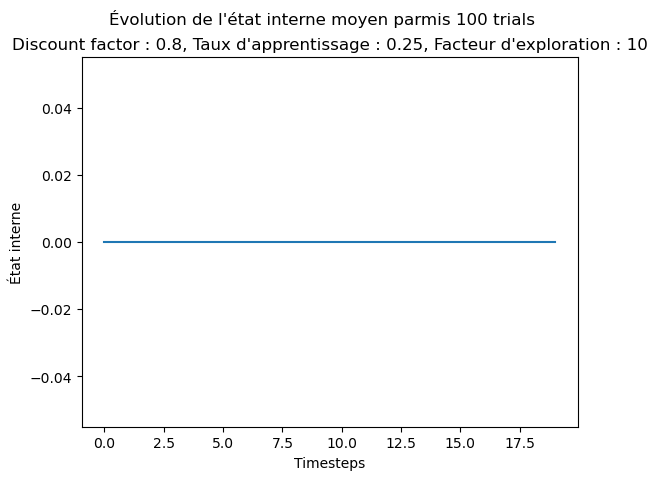

In [19]:
# avg of the 100 trials
state_history = np.mean(state_histories, axis=1)
plt.plot(state_history)
plt.suptitle("Évolution de l'état interne moyen parmis 100 trials")
plt.title(f"Discount factor : {gamma}, Taux d'apprentissage : {alpha}, Facteur d'exploration : {beta}")
plt.xlabel("Timesteps")
plt.ylabel("État interne")
plt.savefig("../figs/aversion_avg_state.png")
plt.show()

In [17]:
print(agent.q_table)

[[ 10.         -10.35684106]
 [-12.3448864   -9.56544875]]
